In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import layers, Model, Sequential
from keras.metrics import Accuracy, Precision, Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import os

In [5]:

# Загрузка данных
current_directory = os.path.dirname(os.getcwd())
data_dir = os.path.join(current_directory, 'pictures', 'lab6_data_images', 'saved')

X = pd.read_csv(f"{data_dir}/imgs.csv")
y = pd.read_csv(f"{data_dir}/msks.csv")

# Удаление лишнего столбца
X.drop(['Unnamed: 0'], axis=1, inplace=True)
y.drop(['Unnamed: 0'], axis=1, inplace=True)

# Преобразование в массивы NumPy
X = np.array(X / 255, dtype=np.float32)
y = np.array(y, dtype=np.int32)

# Преобразование масок
y[y != 1] = 255
y = (y == 255).astype(np.int32)

# Вычисление размера изображений
img_size = int(np.sqrt(X.shape[1] // 3))
if img_size ** 2 * 3 != X.shape[1]:
    raise ValueError("Размеры данных не соответствуют ожидаемым значениям.")

# Преобразование данных в тензоры
X = X.reshape(len(X), img_size, img_size, 3)
y = y.reshape(len(y), img_size, img_size, 1)

# Визуализация
print("Форма X:", X.shape)
print("Форма y:", y.shape)
print("Размер изображений:", img_size)

plt.imshow(y[0].squeeze(), cmap="gray")
plt.title("Маска")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\YasperMoglot\\Desktop\\Ycheba\\4course\\4-course-ai\\pictures\\lab6_data_images/imgs.csv'

In [24]:
# Разделение данных на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# === Полносвязная нейронная сеть ===
dropout_rate = 0.2

fc_model = Sequential([
    layers.Input(shape=(img_size, img_size, 3)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(dropout_rate),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(dropout_rate),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(dropout_rate),
    layers.Dense(img_size * img_size, activation='sigmoid'),
    layers.Reshape((img_size, img_size, 1))
])

fc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# Обучение полносвязной модели

fc_model.fit(x_train, y_train, batch_size=20, epochs=10, validation_split=0.1)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 648ms/step - accuracy: 0.5071 - loss: 0.6962 - val_accuracy: 0.4283 - val_loss: 1.3588
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - accuracy: 0.6047 - loss: 0.6707 - val_accuracy: 0.3561 - val_loss: 3.5325
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - accuracy: 0.6854 - loss: 0.6331 - val_accuracy: 0.3350 - val_loss: 5.3582
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 486ms/step - accuracy: 0.7143 - loss: 0.6043 - val_accuracy: 0.3283 - val_loss: 6.4990
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.7318 - loss: 0.5802 - val_accuracy: 0.3181 - val_loss: 7.0232
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 495ms/step - accuracy: 0.7342 - loss: 0.5680 - val_accuracy: 0.3144 - val_loss: 7.4999
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 507ms/step - accuracy: 0.7522 - loss: 0.5482 - val_accuracy: 0.3102 - val_loss: 7.6306
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 0.7617 - loss: 0.5360 - val_accuracy: 0.3048 - val_loss:

In [32]:
# === Нейронная сеть архитектуры U-Net ===

#ищем локальные признаки
def double_conv_block(x, filters):
    x = layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, filters):
    f = double_conv_block(x, filters)
    p = layers.MaxPool2D(pool_size=2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, filters):
    x = layers.Conv2DTranspose(filters, kernel_size=2, strides=2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, filters)
    return x

def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Слой свертки вниз
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # Бутылочное горлышко
    bottleneck = double_conv_block(p4, 1024)

    # Слой развертки вверх
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # Выходной слой
    outputs = layers.Conv2D(1, kernel_size=1, activation='sigmoid')(u9)
    return Model(inputs, outputs)

# Построение и компиляция модели
unet_model = build_unet((img_size, img_size, 3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# Обучение U-Net модели


unet_model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 115s 27s/step - accuracy: 0.7311 - loss: 114.2142 - val_accuracy: 0.2463 - val_loss: 0.7752
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 94s 27s/step - accuracy: 0.2509 - loss: 0.7837 - val_accuracy: 0.2467 - val_loss: 0.7296
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 95s 27s/step - accuracy: 0.2552 - loss: 0.7365 - val_accuracy: 0.2497 - val_loss: 0.6937
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 106s 29s/step - accuracy: 0.2783 - loss: 0.6959 - val_accuracy: 0.8140 - val_loss: 0.6820
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 94s 27s/step - accuracy: 0.5740 - loss: 0.6866 - val_accuracy: 0.8195 - val_loss: 0.6773
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 94s 27s/step - accuracy: 0.7768 - loss: 0.6771 - val_accuracy: 0.8684 - val_loss: 0.6658
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 95s 28s/step - accuracy: 0.8466 - loss: 0.6668 - val_accuracy: 0.9453 - val_loss: 0.6531
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 94s 27s/step - accuracy: 0.8794 - loss: 0.6526 - val_accuracy: 0.9493 - val_loss: 0.6

In [34]:
# === Анализ результатов ===
def evaluate_model(model, x_data, y_data, model_name):
    predictions = model.predict(x_data)
    predictions_binary = (predictions > 0.5).astype(int)
    acc = accuracy_score(y_data.flatten(), predictions_binary.flatten())
    prec = precision_score(y_data.flatten(), predictions_binary.flatten(), zero_division=0)
    rec = recall_score(y_data.flatten(), predictions_binary.flatten(), zero_division=0)
    print(f"{model_name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

    return predictions

In [35]:
# Оценка полносвязной модели
# Точность-как точно показала,Точность- предсказание на положительность, полнота - доля из всех положительных смогла найти
print("\nПолносвязная модель:")
fc_predictions = evaluate_model(fc_model, x_test, y_test, "Полносвязная модель")

# Оценка U-Net модели
print("\nU-Net модель:")
unet_predictions = evaluate_model(unet_model, x_test, y_test, "U-Net модель")


Полносвязная модель:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Полносвязная модель - Accuracy: 0.2903, Precision: 0.8400, Recall: 0.0636

U-Net модель:
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
U-Net модель - Accuracy: 0.9325, Precision: 0.9846, Recall: 0.9243


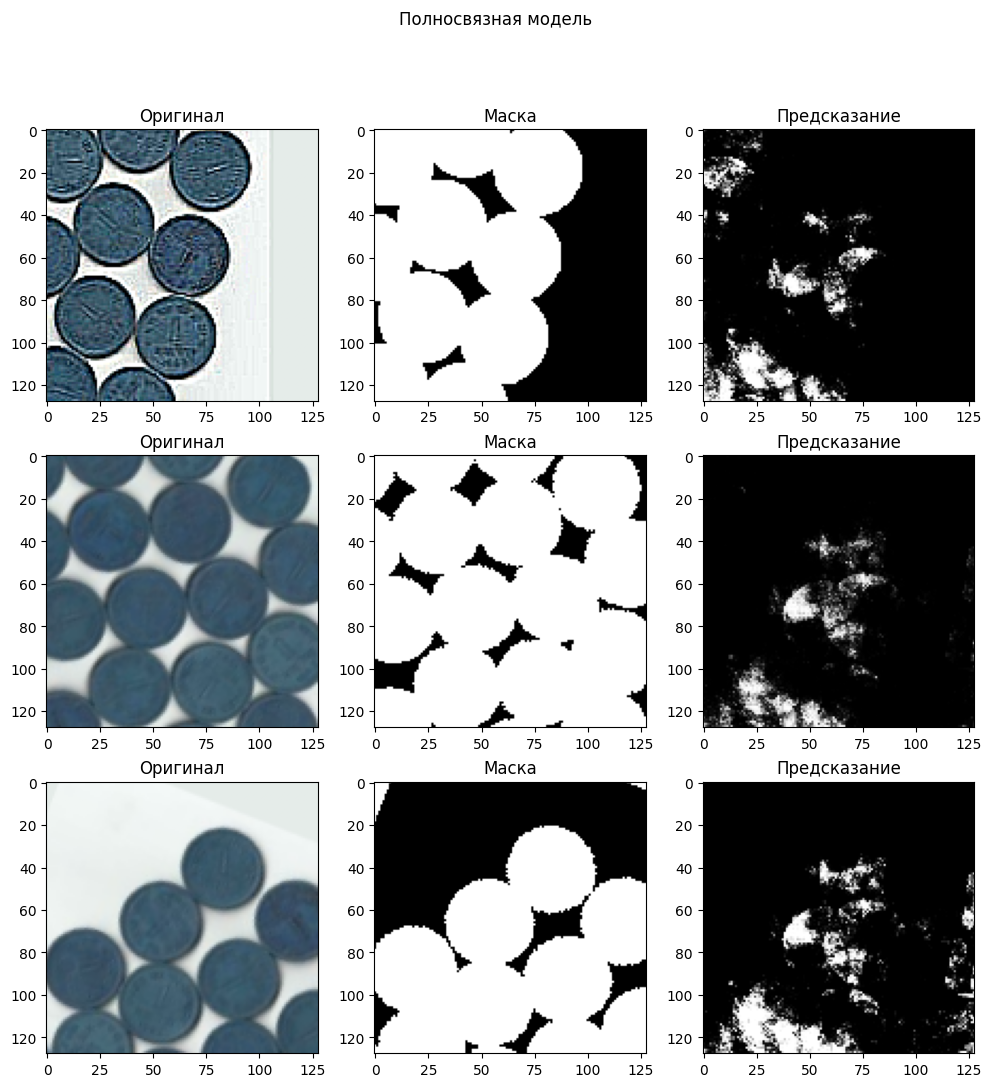

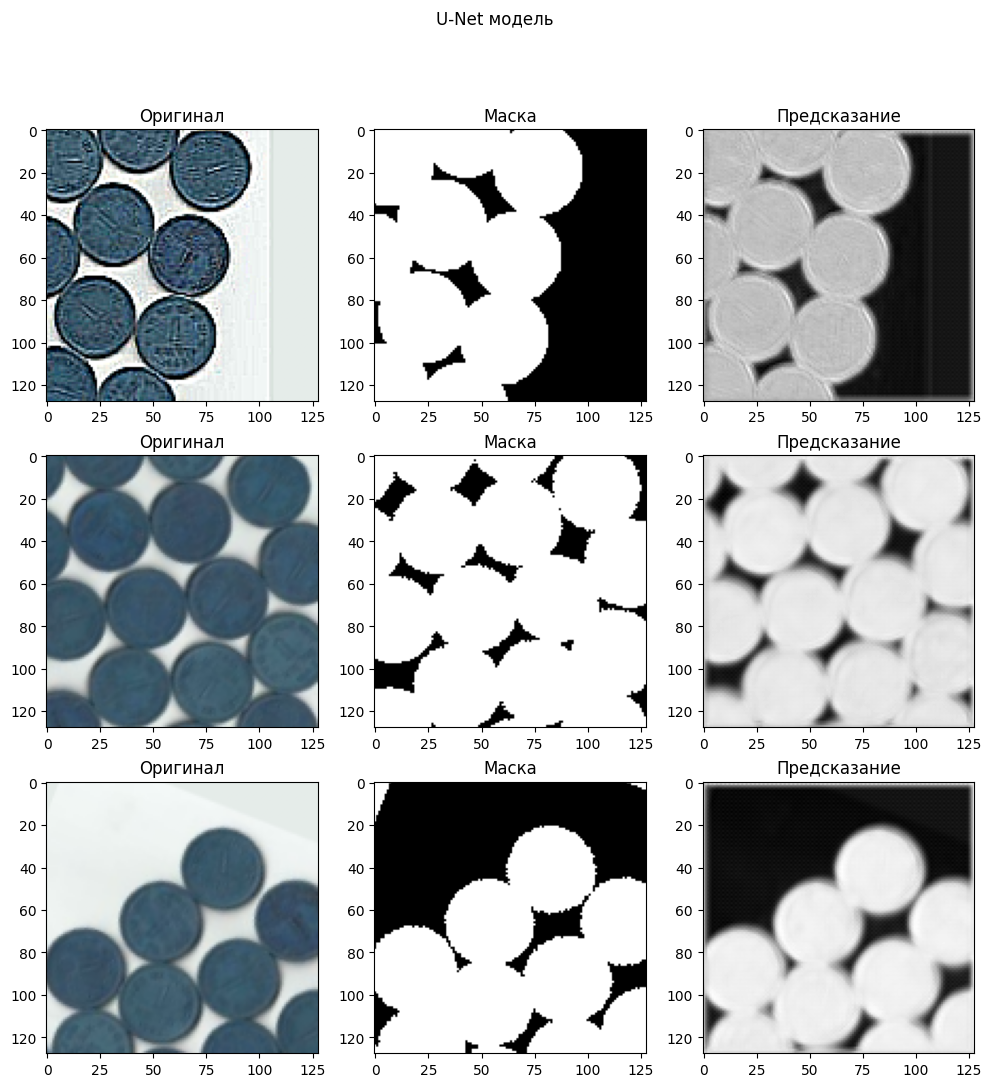

In [36]:
# === Визуализация ===
def visualize_results(images, masks, predictions, title):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for i in range(3):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title("Оригинал")
        axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')
        axes[i, 1].set_title("Маска")
        axes[i, 2].imshow(predictions[i].squeeze(), cmap='gray')
        axes[i, 2].set_title("Предсказание")
    plt.suptitle(title)
    plt.show()

# Визуализация для полносвязной модели
visualize_results(x_test[:3], y_test[:3], fc_predictions[:3], "Полносвязная модель")

# Визуализация для U-Net модели
visualize_results(x_test[:3], y_test[:3], unet_predictions[:3], "U-Net модель")